#Import Libraries

In [1]:
%tensorflow_version 2.x

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pathlib

from __future__ import print_function
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Flatten,  Conv2D, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import AveragePooling2D, Input
from tensorflow.keras.layers import MaxPool2D, MaxPool1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
#from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import numpy as np
import os

from google.colab import drive

print("Module Loaded.")
print("TensorFlow Version :{}".format(tf.__version__))
print("NumPy Version :{}".format(np.__version__))
print("Matplotlib Version :{}".format(plt.matplotlib.__version__))

TensorFlow 2.x selected.
Module Loaded.
TensorFlow Version :2.0.0
NumPy Version :1.17.4
Matplotlib Version :3.1.2


In [2]:
drive.mount('/content/drive')

data_path = pathlib.Path('/content/drive/Shared drives/scsa_2019_b/Project_Ai-KEA/data/furniture')

num = 0

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
class_name = np.array([item.name for item in data_path.glob('*')])
print(class_name)

['rug' 'curtain' 'table' 'bed' 'bookshelves' 'sofa' 'makeup_table' 'chair'
 'standing_lamp' 'entertainment_center']


# Prepare Data

- **Unzip Data**

In [4]:
import os

cwd = os.getcwd()
print(cwd)

# !unzip /content/drive/Shared\ drives/scsa_2019_b/Project_Ai-KEA/data_resize/furniture.zip

/content


In [0]:
# Training parameters

num_classes = 10

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True

# Model parameter

# ResNet14   n=2
# ResNet20   n=3 
# ResNet32   n=5     
n = 1 #3

# Model version
version = 1

# Computed depth from supplied model parameter n
depth = n * 6 + 2

# Model name, depth and version
model_name = 'ResNet%dv%d' % (depth, version)

# Resize Image

In [0]:
# from PIL import Image

# for j in class_name[1:4]:
#     image = pathlib.Path('/content/drive/Shared drives/scsa_2019_b/Project_Ai-KEA/data/furniture/'+j)
#     image = list(image.glob('*.jpg'))
#     for i in range(len(image)):
#         im = Image.open(str(image[i])).convert('RGB')
#         resize_image = im.resize((im.size[0]//2,im.size[1]//2))
#         resize_image.save('/content/drive/Shared drives/scsa_2019_b/Project_Ai-KEA/data_resize/furniture/{0}/{1}{2:03d}.jpg'.format(j,j,i))
#         print(j, i)

In [0]:
data_path = pathlib.Path('/content/drive/Shared drives/scsa_2019_b/Project_Ai-KEA/data_resize/furniture')

#ImageGenerator

In [0]:
img_size = 224
batch_n = 200

data_path = pathlib.Path('/content/furniture')

In [0]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
                                #width_shift_range=0.3,
                                #height_shift_range=0.3,
                                #horizontal_flip=True, 
                                #vertical_flip=True,
                                #rotation_range=30,
                                #zoom_range=0.1,
                                #brightness_range=[0.8,1.2],
                                validation_split=0.2,
                                rescale=1./255)

In [10]:
train_data_generate = image_generator.flow_from_directory(
                        directory=str(data_path),
                        batch_size=batch_n,
                        shuffle=True,
                        target_size=(img_size, img_size),
                        classes = list(class_name),
                        subset='training')
test_data_generate = image_generator.flow_from_directory(
                        directory=str(data_path),
                        batch_size=batch_n,
                        shuffle=True,
                        target_size=(img_size, img_size),
                        classes = list(class_name),
                        subset='validation')

Found 3705 images belonging to 10 classes.
Found 921 images belonging to 10 classes.


In [11]:
# print(len(*train_data_generate))

KeyboardInterrupt: ignored

In [0]:
save_path = '/content/drive/Shared drives/scsa_2019_b/Project_Ai-KEA/code/model_checkpoint/'
date = 'day01'
epoch_n = 10
model_name = 'aikea_{}_{}_{}_{}.hdf5'.format(date, epoch_n, model_name, 0)
if not os.path.isdir(save_path):
    os.makedirs(save_path)
filepath = os.path.join(save_path, model_name)

# Load Prev Model

In [0]:
# title format : aikea-{day01}-{sey}
def save_model(date, epoch, model_name, num):
    ai_kea.save(save_path+"aikea_{}_{}_{}_{}.hdf5".format(date, epoch, model_name, num))

In [0]:
def load_model(date, epoch, model_name, num):
  model = load_model(save_path+"aikea_{}_{}_{}_{}.hdf5".format(date, epoch, model_name, num))
  return model

In [0]:
# prev_ai_kea = load_models("mnist",500)

#Load ResNet

In [0]:
def lr_schedule(epoch):
    lr = 1e-2
    if epoch/epoch_n > 0.7:
        lr *= 0.5e-3
    elif epoch/epoch_n > 0.6:
        lr *= 1e-3
    elif epoch/epoch_n > 0.3:
        lr *= 1e-2
    elif epoch/epoch_n > 0.1:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [0]:
# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_acc',
                             verbose=1, save_best_only=True)

In [0]:
lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0,
                               patience=5, min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

In [0]:
def resnet_layer(inputs,num_filters=16,kernel_size=3,strides=1,
                 activation='relu',batch_normalization=True,conv_first=True):
 
    conv = Conv2D(num_filters, kernel_size=kernel_size,
                  strides=strides, padding='same',kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:          # conv first
        x = conv(x)
        if batch_normalization :
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:                   # activation first
        if batch_normalization :
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [0]:
def resnet_v1(input_shape, depth, num_classes=10):
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)           # first resnet
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,num_filters=num_filters,strides=strides)
            y = resnet_layer(inputs=y,num_filters=num_filters,activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,num_filters=num_filters,kernel_size=1,
                                 strides=strides,activation=None,batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [80]:
ai_kea = resnet_v1(input_shape=(img_size,img_size, 3), depth=depth)

ai_kea.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])
ai_kea.summary()
print(model_name)

Learning rate:  0.01
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 112, 112, 3) 0                                            
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 112, 112, 16) 448         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_21 (BatchNo (None, 112, 112, 16) 64          conv2d_28[0][0]                  
__________________________________________________________________________________________________
activation_21 (Activation)      (None, 112, 112, 16) 0           batch_normalization_21[0][0]     
_______________________________________________________________________

- Check Point

#model compile & train

In [0]:
from tensorflow.keras.optimizers import Adam

In [0]:
ai_kea.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

In [83]:
%%time
batch_size = 80  # orig paper trained all networks with batch_size=128
epoch_n = 150  # 50
# Run training, with or without data augmentation.
data_augmentation = False

if not data_augmentation:
    print('Not using data augmentation.')
    history = ai_kea.fit(train_data_generate, epochs=epoch_n,
                  validation_data=test_data_generate, shuffle=True,
                  callbacks=callbacks)
    # Score trained model.
    scores = model.evaluate(test_data_generate, verbose=1)
    print('Test loss:', scores[0])
    print('Test accuracy:', scores[1])

Not using data augmentation.
Train for 19 steps, validate for 5 steps
Learning rate:  0.01
Epoch 1/150
19/19 [==============================] - 16s 816ms/step - loss: 2.5735 - accuracy: 0.2418 - val_loss: 133.7457 - val_accuracy: 0.1194
Learning rate:  0.01
Epoch 2/150
19/19 [==============================] - 14s 728ms/step - loss: 1.8253 - accuracy: 0.3906 - val_loss: 98.0170 - val_accuracy: 0.0706
Learning rate:  0.01
Epoch 3/150
19/19 [==============================] - 14s 721ms/step - loss: 1.5605 - accuracy: 0.4993 - val_loss: 10.2427 - val_accuracy: 0.1107
Learning rate:  0.01
Epoch 4/150
19/19 [==============================] - 14s 730ms/step - loss: 1.4090 - accuracy: 0.5552 - val_loss: 4.0422 - val_accuracy: 0.1933
Learning rate:  0.01
Epoch 5/150
19/19 [==============================] - 14s 715ms/step - loss: 1.2934 - accuracy: 0.6022 - val_loss: 2.6670 - val_accuracy: 0.3246
Learning rate:  0.01
Epoch 6/150
19/19 [==============================] - 14s 718ms/step - loss: 1.21

KeyboardInterrupt: ignored

# Save Model

In [84]:
%%time

# date, epoch, model_name, num
save_model(date, epoch=epoch_n, model_name=model_name, num='sey02')

CPU times: user 94.5 ms, sys: 9.88 ms, total: 104 ms
Wall time: 130 ms


# Plot Learning Status

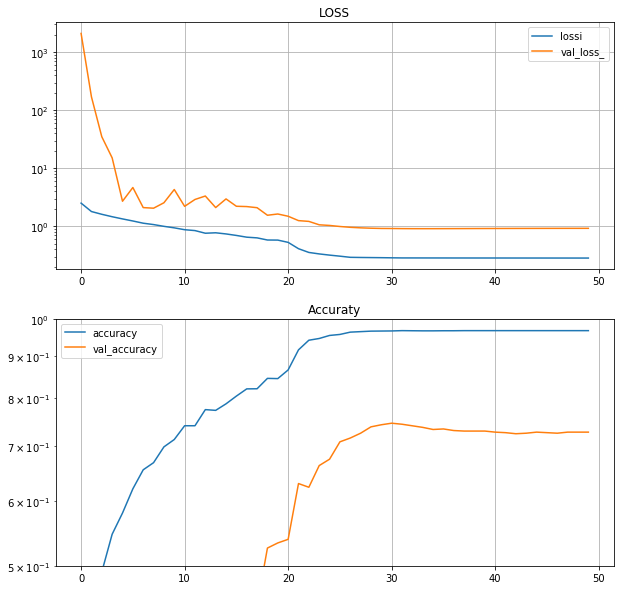

In [85]:
import matplotlib.pyplot as plt

losses = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.semilogy(losses, label='lossi')
plt.semilogy(val_loss, label='val_loss_')
plt.grid(True)
plt.legend(loc='best')
plt.title("LOSS")

plt.subplot(2, 1, 2)
plt.ylim(0.5,1)
plt.semilogy(acc, label='accuracy')
plt.semilogy(val_acc, label='val_accuracy')
plt.grid(True)
plt.legend(loc='best')
plt.title("Accuraty")
plt.show()  

In [86]:
print(np.max(history.history['val_accuracy']))

0.74592835
